# 계층적군집(4) - EastWestAirlines Data

## 군집분석에서 중요한 점

### 1. 너무 많은 변수를 사용할 위험

군집분석은 주로 고객을 분류하는데에 사용

변수를 이것 저것 다 넣으면 `기계가 알아서 해주겠지`하는 기대 심리를 경계

#### 변수를 너무 많이 넣을 경우

1. 알고리즘 실행시간 증가
2. 모델이 복잡해져 과적합 위험 증가
3. 결과 검토에 대한 난이도가 증가

### 2. 변수간 관계 미리보기

#### 변수간의 상관관계 확인

1. 상관계수 히트맵
2. 산점도 행렬

#### 주성분(PCA) 분석 활용하기

주성분(PCA) 분석은 데이터의 특징을 최대한 손실 없이 살리면서 데이터의 차원을 축소하는 기법

클러스터링 분석에서도 취급하는 변수의 수를 줄일 때 유용하게 사용할 수 있다

### 3. 그 밖의 내용

1. 문자열 데이터는 불가. 존재한다면 미리 라벨링 진행
    - 명목형 변수는 결과에 큰 영향을 미치지 않음
2. 이상치에 민감하므로 이상치 정제 혹은 표준화를 수행
    - `도메인 지식에 근거한` 분석가의 주관으로 판단하는 것도 하나의 방법
    - 대부분의 이상치는 표준화를 진행하면 해결

## 군집분석의 결과

비지도 학습이므로 정답이 없는 상태에서 시작하므로 훈련/검증 데이터를 분할할 필요가 없다

군집의 결과 역시 정답이 아닐 수도 있음

적용 가능한 하이터 파라미터들을 다양하게 설정해 시각화 결과가 가장 고르게 군집을 형성하는 경우를 선택. 선택 기준에 실루엣 점수를 반영하는 것도 고려할 수 있다(실루엣 계수는 군집분석에서 절대적인 계수가 될 수는 없기 때문).

## #01. 패키지

In [1]:
import warnings
warnings.filterwarnings('ignore')

import seaborn as sb
import numpy as np
from itertools import product   #list 2개의 조합을 생성
from matplotlib import pyplot as plt
from pandas import read_excel, DataFrame
from scipy.cluster.hierarchy import dendrogram, linkage

# sklearn은 AgglomerativeClustering() 함수를 제공
from sklearn.cluster import AgglomerativeClustering

# 표준화
from sklearn.preprocessing import StandardScaler

## #02. 데이터

- Balance : 보너스 여행에 적합한 마일리지
- Qual_miles : Topflight 자격 취득에 필요한 마일리지 수
- cc1_miles : 지난 12개월 동안 신용카드 사용에 의해 적립된 마일리지
- cc2_miles : 지난 12개월 동안 Rewards 카드로 적립된 마일리지
- cc3_miles : 지난 12개월 동안 법인 카드로 적립된 마일리지
- Bonus_miles : 지난 12개월 동안 항공권 외 보너스 거래를 통해 적립된 마일리지
- Bonus_trans : 지난 12개월 동안 항공권 외 보너스 거래 수
- Flight_miles_12mo : 지난 12개월 동안 비행 마일리지
- Flight_trans_12 : 지난 12개월 동안 항공권 거래 건수
- Days_since_enroll : 플그램에 가입한 여부
- Award : 보너스 항공권을 받았는지 여부

In [2]:
origin = read_excel("https://data.hossam.kr/G02/EastWestAirlines.xlsx", index_col="ID")
print(origin.info())
origin.head()

<class 'pandas.core.frame.DataFrame'>
Index: 3999 entries, 1 to 4021
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   Balance            3999 non-null   int64
 1   Qual_miles         3999 non-null   int64
 2   cc1_miles          3999 non-null   int64
 3   cc2_miles          3999 non-null   int64
 4   cc3_miles          3999 non-null   int64
 5   Bonus_miles        3999 non-null   int64
 6   Bonus_trans        3999 non-null   int64
 7   Flight_miles_12mo  3999 non-null   int64
 8   Flight_trans_12    3999 non-null   int64
 9   Days_since_enroll  3999 non-null   int64
 10  Award              3999 non-null   int64
dtypes: int64(11)
memory usage: 374.9 KB
None


,Balance,Qual_miles,cc1_miles,cc2_miles,cc3_miles,Bonus_miles,Bonus_trans,Flight_miles_12mo,Flight_trans_12,Days_since_enroll,Award
ID,,,,,,,,,,,
1,28143,0,1,1,1,174,1,0,0,7000,0
2,19244,0,1,1,1,215,2,0,0,6968,0
3,41354,0,1,1,1,4123,4,0,0,7034,0
4,14776,0,1,1,1,500,1,0,0,6952,0
5,97752,0,4,1,1,43300,26,2077,4,6935,1


> 전체 데이터 형태가 int이므로 따로 라벨링이 필요하지는 않음.

> 결측치 존재 여부와 이상치 여부를 확인. 결측치는 정제된 데이터

## #03. 결측치/이상치 확인

In [3]:
# 결측치 확인
origin.isna().sum()

Balance              0
Qual_miles           0
cc1_miles            0
cc2_miles            0
cc3_miles            0
Bonus_miles          0
Bonus_trans          0
Flight_miles_12mo    0
Flight_trans_12      0
Days_since_enroll    0
Award                0
dtype: int64

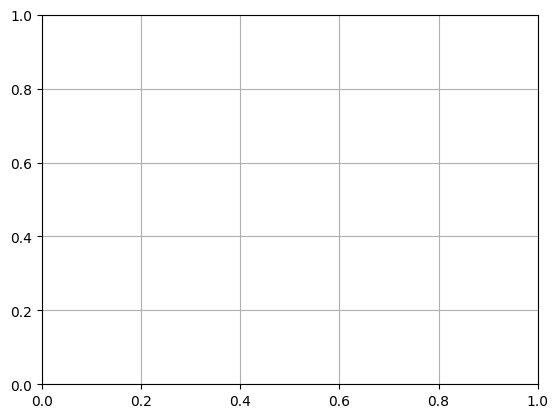

In [4]:
plt.figure()
plt.grid()
plt.show()
plt.close()

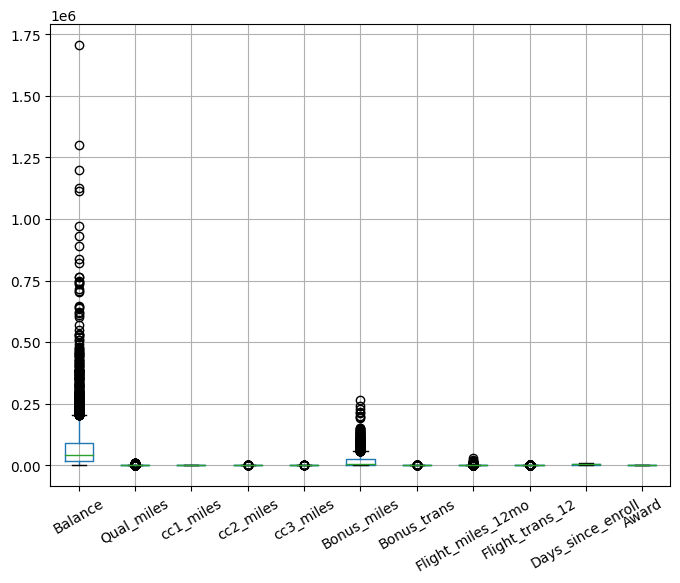

In [5]:
# 이상치 확인 boxplot
plt.figure(figsize=(8,6))
origin.boxplot()
plt.xticks(rotation=30)
plt.show()
plt.close()

> 다수의 이상치가 관측되어 스케일링을 진행

> 이상치로 보이는 값이 관측되지만 실제로는 이상치 제거보다는 스케일링을 통한 이상치 정제가 더 활발

## #04. 데이터 표준화

표준화를 진행하면 numpy(2차원) 배열로 변경

이제는 표준화를 통해 생성된 numpy를 DF 형태로 변경 후 분석에 사용

In [6]:
scaler = StandardScaler()
n_data = scaler.fit_transform(origin)
# 원본 데이터의 index가 의미없이 0부터 시작할 경우 DF에서 따로 index를 지정하지 않음
# 원본 데이터의 column을 index로 지정하거나 index가 의미가 있다면 DF에서 index를 지정
ndf = DataFrame(n_data, columns=origin.columns, index=origin.index)
ndf.head()

,Balance,Qual_miles,cc1_miles,cc2_miles,cc3_miles,Bonus_miles,Bonus_trans,Flight_miles_12mo,Flight_trans_12,Days_since_enroll,Award
ID,,,,,,,,,,,
1,-0.451141,-0.186299,-0.769578,-0.098242,-0.062767,-0.702786,-1.104065,-0.328603,-0.362168,1.395454,-0.766919
2,-0.539457,-0.186299,-0.769578,-0.098242,-0.062767,-0.701088,-0.999926,-0.328603,-0.362168,1.379957,-0.766919
3,-0.320031,-0.186299,-0.769578,-0.098242,-0.062767,-0.539253,-0.791649,-0.328603,-0.362168,1.411920,-0.766919
4,-0.583799,-0.186299,-0.769578,-0.098242,-0.062767,-0.689286,-1.104065,-0.328603,-0.362168,1.372208,-0.766919
5,0.239678,-0.186299,1.409471,-0.098242,-0.062767,1.083121,1.499394,1.154932,0.692490,1.363975,1.303918


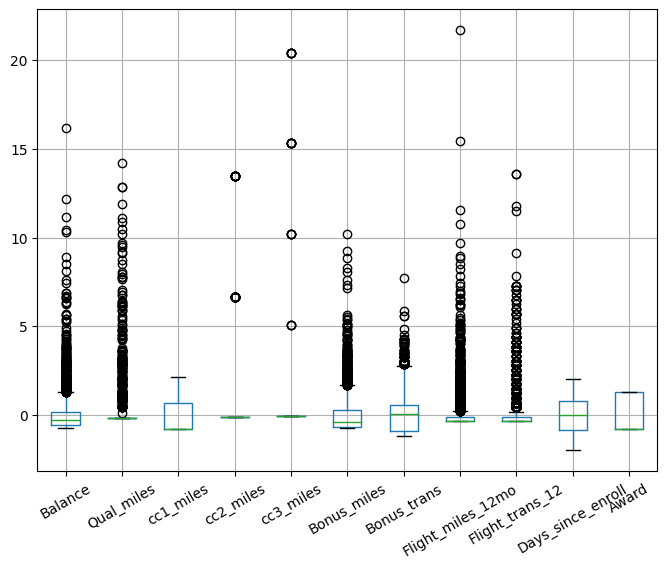

In [7]:
# 이상치 정제 확인 boxplot
plt.figure(figsize=(8,6))
ndf.boxplot()
plt.xticks(rotation=30)
plt.show()
plt.close()

> 표준화 전과 비교했을 때 비교적 균일하게 분포되었다고 판단

적성적으로는 추가적인 정제가 필요함.

## #05. 기초 통계량 확인

In [8]:
ndf.describe()

,Balance,Qual_miles,cc1_miles,cc2_miles,cc3_miles,Bonus_miles,Bonus_trans,Flight_miles_12mo,Flight_trans_12,Days_since_enroll,Award
count,3.999000e+03,3.999000e+03,3.999000e+03,3.999000e+03,3.999000e+03,3.999000e+03,3.999000e+03,3999.000000,3.999000e+03,3.999000e+03,3.999000e+03
mean,2.842882e-17,6.574164e-17,1.705729e-16,3.038330e-16,1.350369e-16,-2.842882e-17,-7.817925e-17,0.000000,1.776801e-17,5.685763e-17,1.421441e-17
std,1.000125e+00,1.000125e+00,1.000125e+00,1.000125e+00,1.000125e+00,1.000125e+00,1.000125e+00,1.000125,1.000125e+00,1.000125e+00,1.000125e+00
min,-7.304396e-01,-1.862987e-01,-7.695784e-01,-9.824189e-02,-6.276658e-02,-7.099918e-01,-1.208203e+00,-0.328603,-3.621679e-01,-1.993611e+00,-7.669193e-01
25%,-5.465676e-01,-1.862987e-01,-7.695784e-01,-9.824189e-02,-6.276658e-02,-6.582276e-01,-8.957878e-01,-0.328603,-3.621679e-01,-8.661823e-01,-7.669193e-01
50%,-3.027332e-01,-1.862987e-01,-7.695784e-01,-9.824189e-02,-6.276658e-02,-4.130308e-01,4.145743e-02,-0.328603,-3.621679e-01,-1.092530e-02,-7.669193e-01
75%,1.866028e-01,-1.862987e-01,6.831212e-01,-9.824189e-02,-6.276658e-02,2.756198e-01,5.621492e-01,-0.106466,-9.850333e-02,8.097050e-01,1.303918e+00
max,1.618884e+01,1.422486e+01,2.135821e+00,1.344898e+01,2.042732e+01,1.020957e+01,7.747696e+00,21.683004,1.361205e+01,2.023095e+00,1.303918e+00


## #06. 각 변수간의 상관관계 확인

<Figure size 640x480 with 0 Axes>

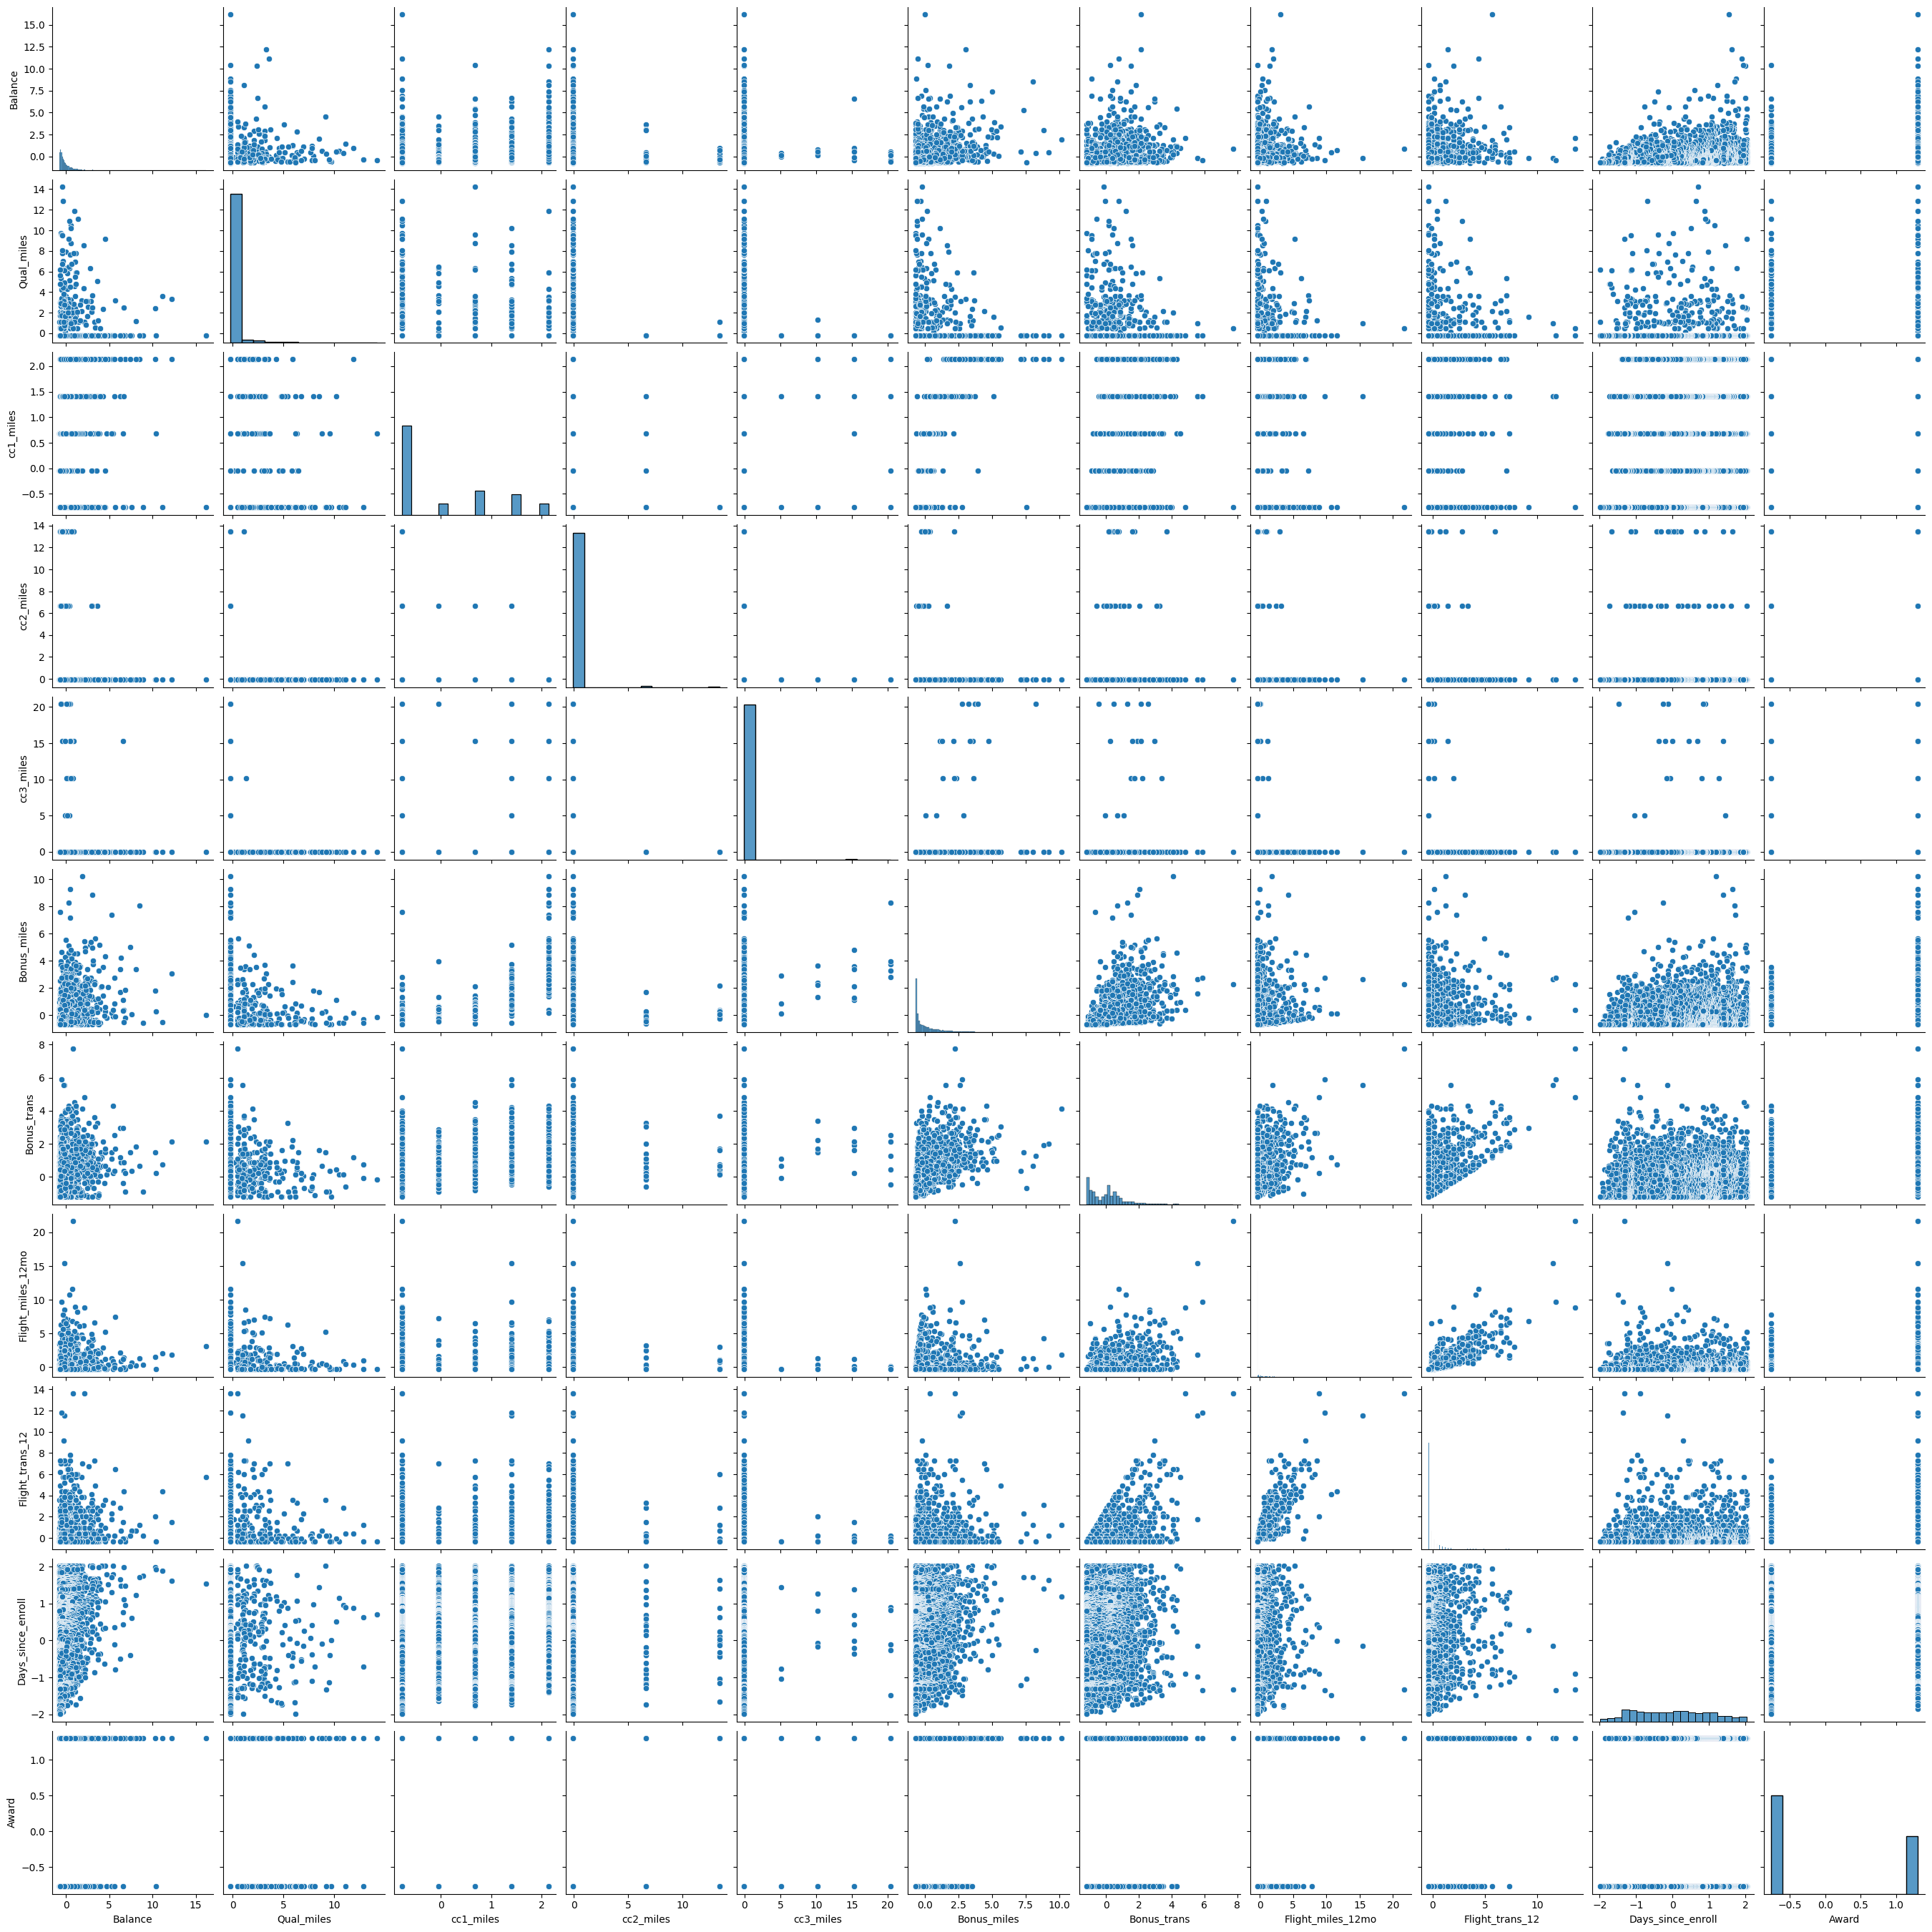

In [9]:
plt.figure()
sb.pairplot(ndf)
# plt.grid()
plt.show()
plt.close()

> 산점도 행렬만으로 특징을 도출/판단하기에는 무리가 있음

## #07. 상관계수 히트맵

히트맵을 통해 특별히 높은 상관성을 보이는 변수 묶음들이 있는지 확인 가능

묶음 별로 상대적으로 중요도가 낮다고 판단되는 변수는 분석에서 제외할 수 있음

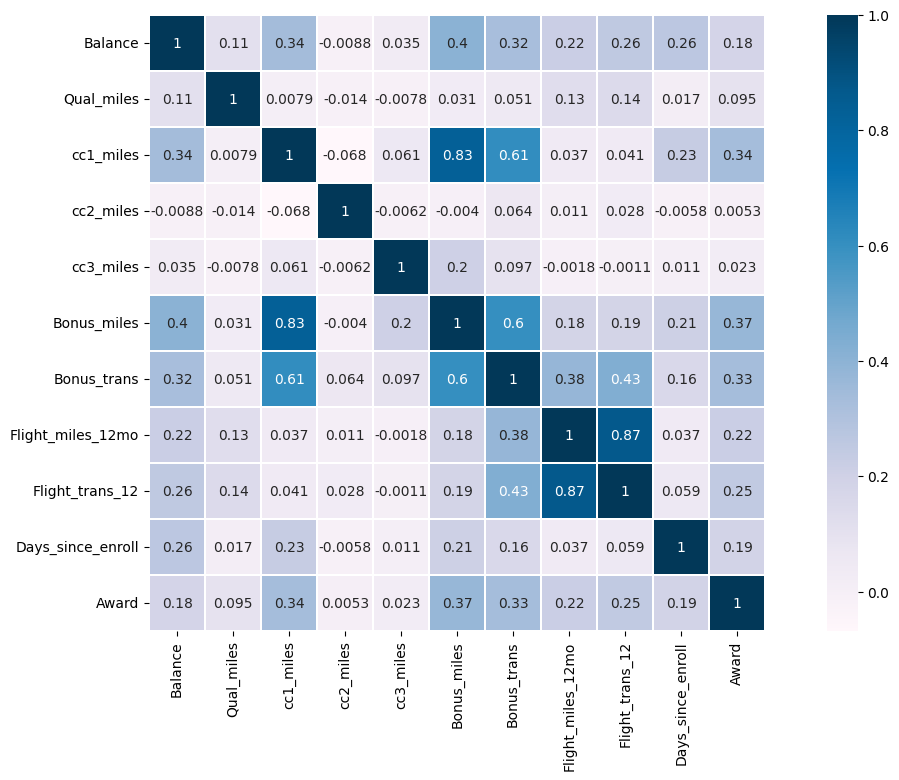

In [10]:
plt.figure(figsize=(16,8))
sb.heatmap(ndf.corr(), linewidths=0.1, vmax=1.0,
           square=True, cmap=plt.cm.PuBu,
           linecolor="white", annot=True,
           annot_kws={"size":10})
plt.show()
plt.close()

> Balance, cc1_miles, Bonus_miles, Bonus_trans, Flight_miles_12mo, Flight_trans_12를 주요 변수로 판단.

## #08. 대상 변수 필터링

In [11]:
# 예제 구성을 위해 테스트 한 다른 변수집합들
# -> 3개의 군집을 형성
# x = ndf.filter(['Balance','cc1_miles','Bonus_miles','Bonus_trans',
#                 'Fight_miles_12mo', 'Fight_trans_12', 'Days_since_enroll'])
# x = ndf.filter(['Balance','cc1_miles','cc2_miles','cc3_miles',
#                 'Bonus_miles','Bonus_trans', 'Days_since_enroll'])


# 최종 선정된 변수 집합
x = ndf.filter(['Balance', 'cc1_miles', 'Bonus_miles', 'Bonus_trans', 
                'Flight_miles_12mo', 'Flight_trans_12'])
x.head()

,Balance,cc1_miles,Bonus_miles,Bonus_trans,Flight_miles_12mo,Flight_trans_12
ID,,,,,,
1,-0.451141,-0.769578,-0.702786,-1.104065,-0.328603,-0.362168
2,-0.539457,-0.769578,-0.701088,-0.999926,-0.328603,-0.362168
3,-0.320031,-0.769578,-0.539253,-0.791649,-0.328603,-0.362168
4,-0.583799,-0.769578,-0.689286,-1.104065,-0.328603,-0.362168
5,0.239678,1.409471,1.083121,1.499394,1.154932,0.692490


## #09. 군집분석 수행

### method 파라미터

군집간의 거리를 구하는 방법

`single`(기본 값), `complete`, `average`, `weighted`, `centroid` , `ward` 중 선택

> 참고 : https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html

### metric 파라미터

> scipy.spatial.distance.pdist 클래스의 인스턴스

- `euclidean(직선)` : metric의 기본이며 점 사이의 `직선 거리 측정`
- `cityblock` : 점 사이의 `맨하탄 거리 측정(블록 형태)`
- `seuclidean` : 표준화된 유클리디안
- `sqeuclidean` : 제곱된 유클리디안
- `cosine` : 코사인 거리 계산
- 콜백함수 지정 가능

> 참고 : https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.pdist.html#scipy-spatial-distance-pdist

scipy : 군집을 몇 개로 나누면 되는지 판단하기에는 좋음. 단, 각 그룹이 몇번 그룹에 속한지 알기는 어려움

sklearn : 각 데이터가 속한 그룹을 알기 쉬움. 떄문에 scipy로 분석한 데이터를 사용, 각 그룹이 몇 번 그룹에 속한지를 도출 가능

In [12]:
# method = ['single', 'complete', 'average', 'weighted', 'centroid', 'ward']    #오래걸림
method = ['single', 'complete', 'average', 'ward']
metric = ['euclidean', 'cityblock']

# 2개의 list 조합
# from itertools import product을 사용해 2중 반복문 억제
prod = list(product(*[method, metric]))
prod

[('single', 'euclidean'),
 ('single', 'cityblock'),
 ('complete', 'euclidean'),
 ('complete', 'cityblock'),
 ('average', 'euclidean'),
 ('average', 'cityblock'),
 ('ward', 'euclidean'),
 ('ward', 'cityblock')]

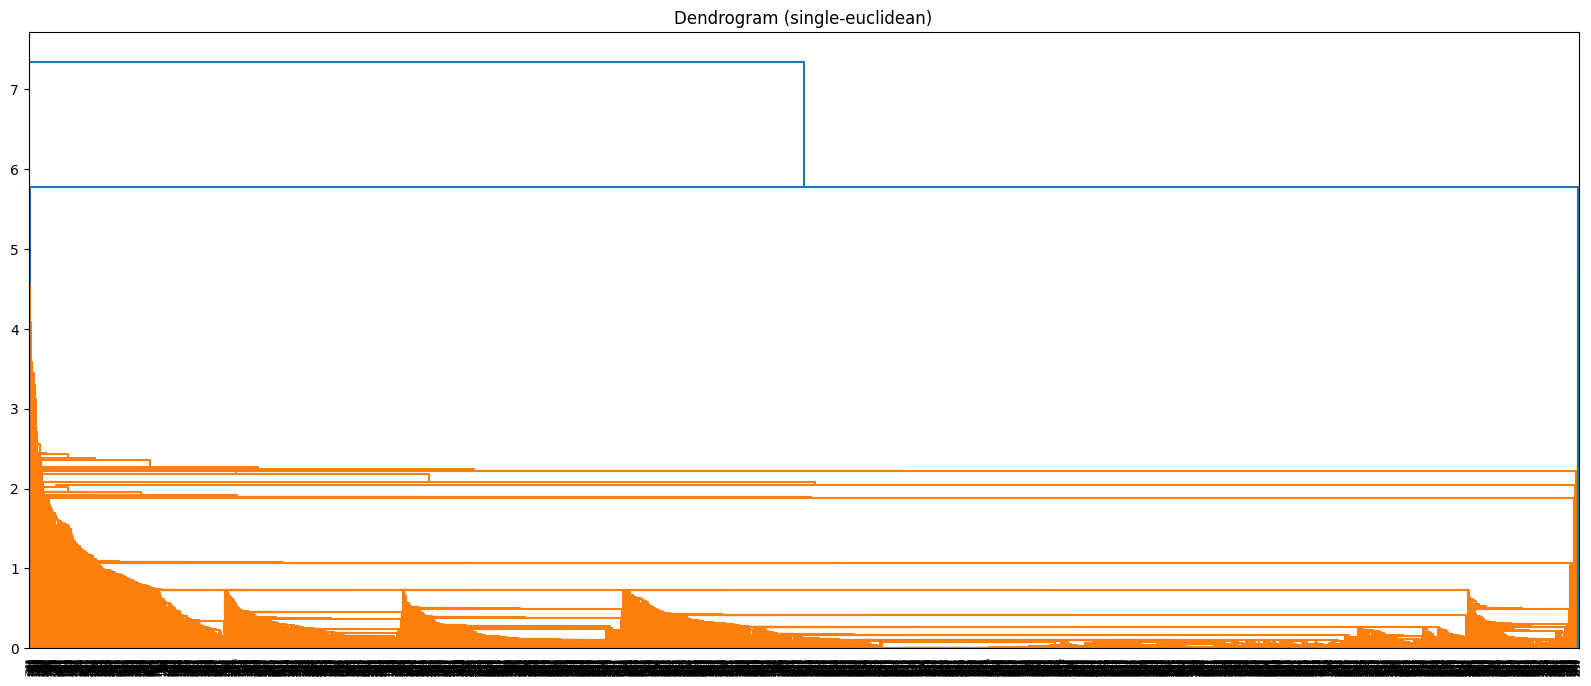

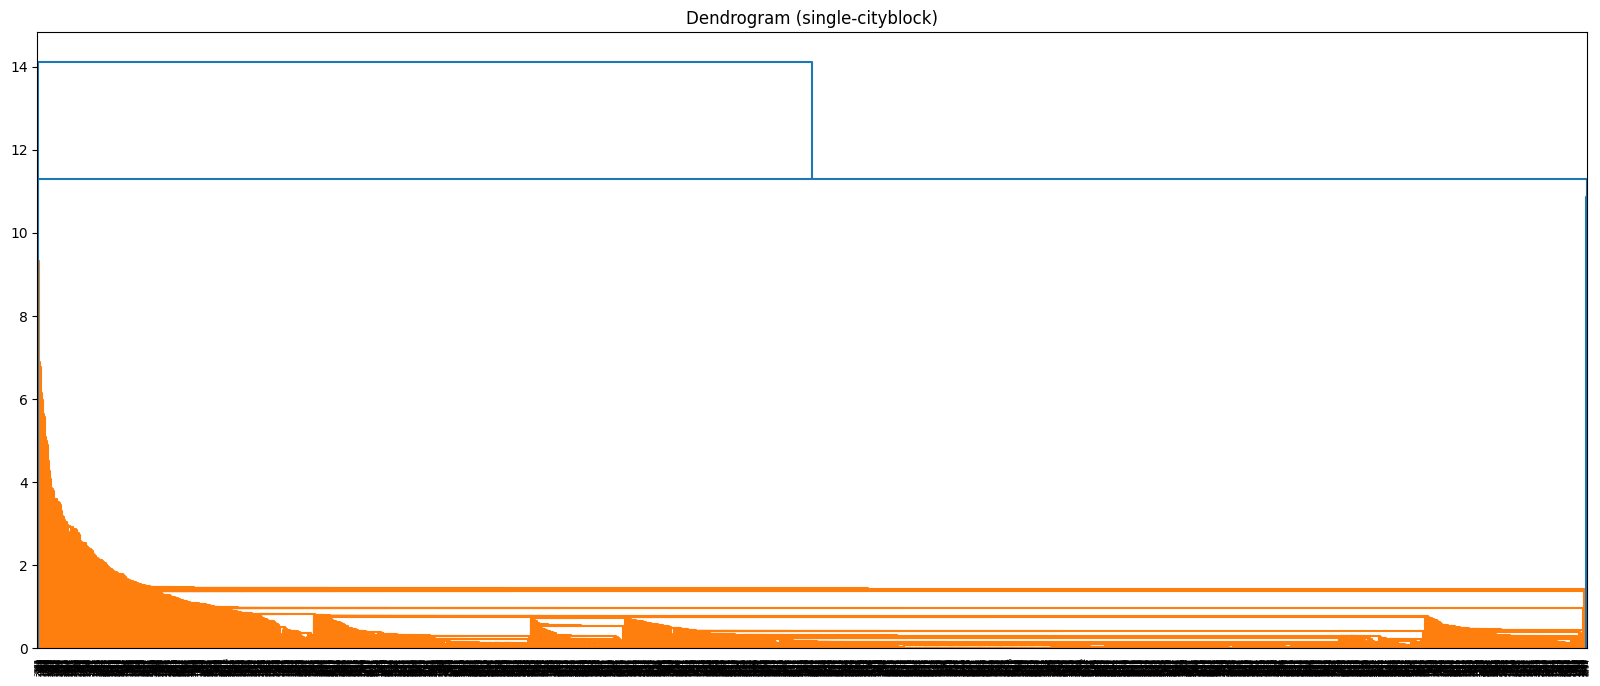

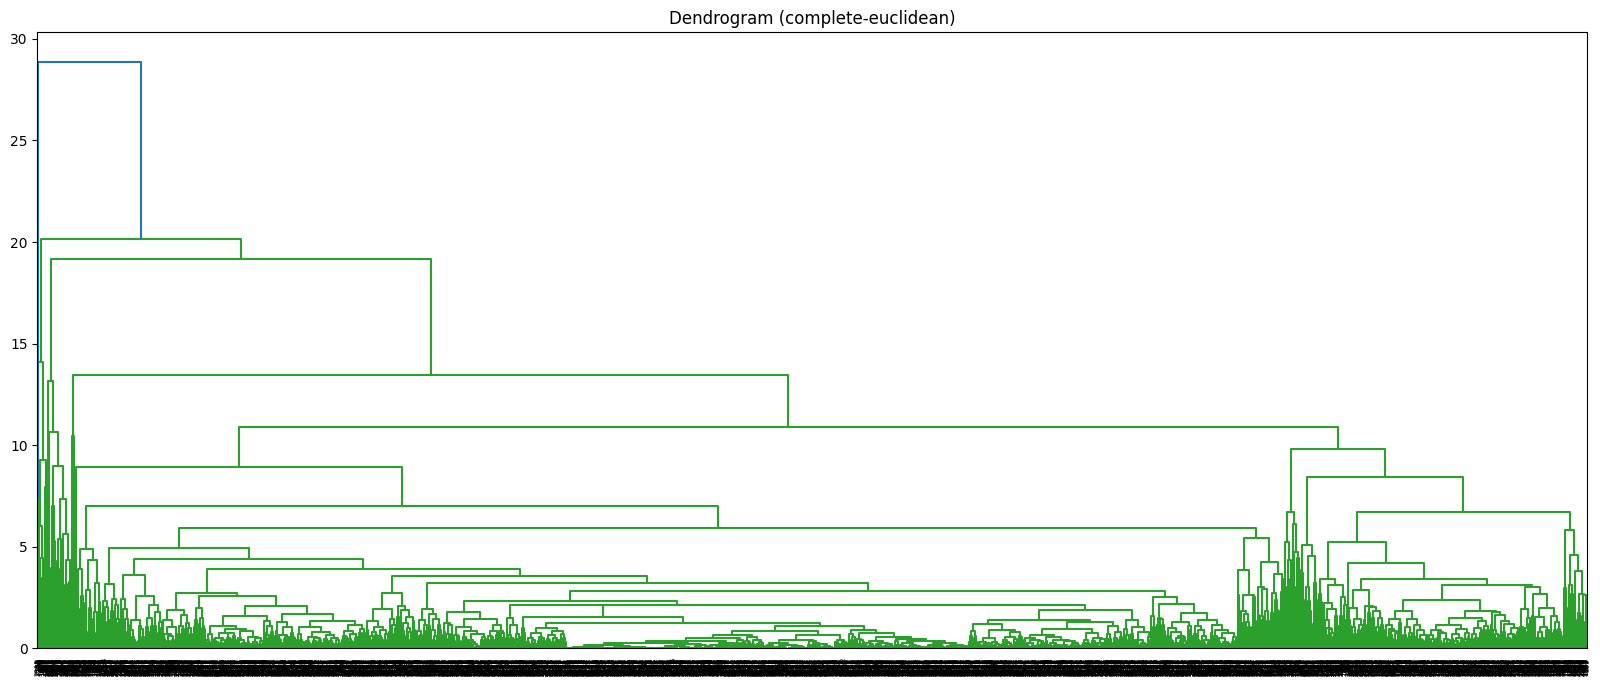

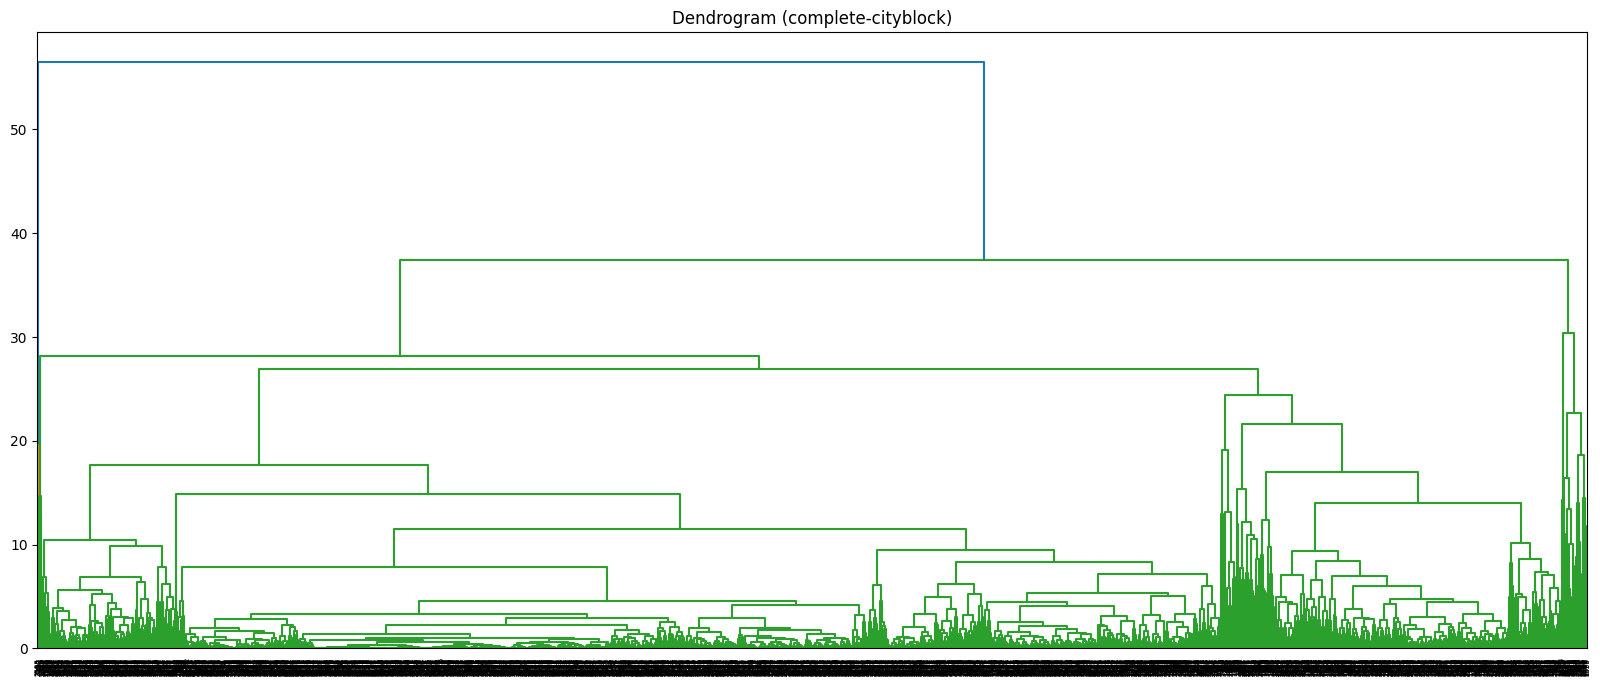

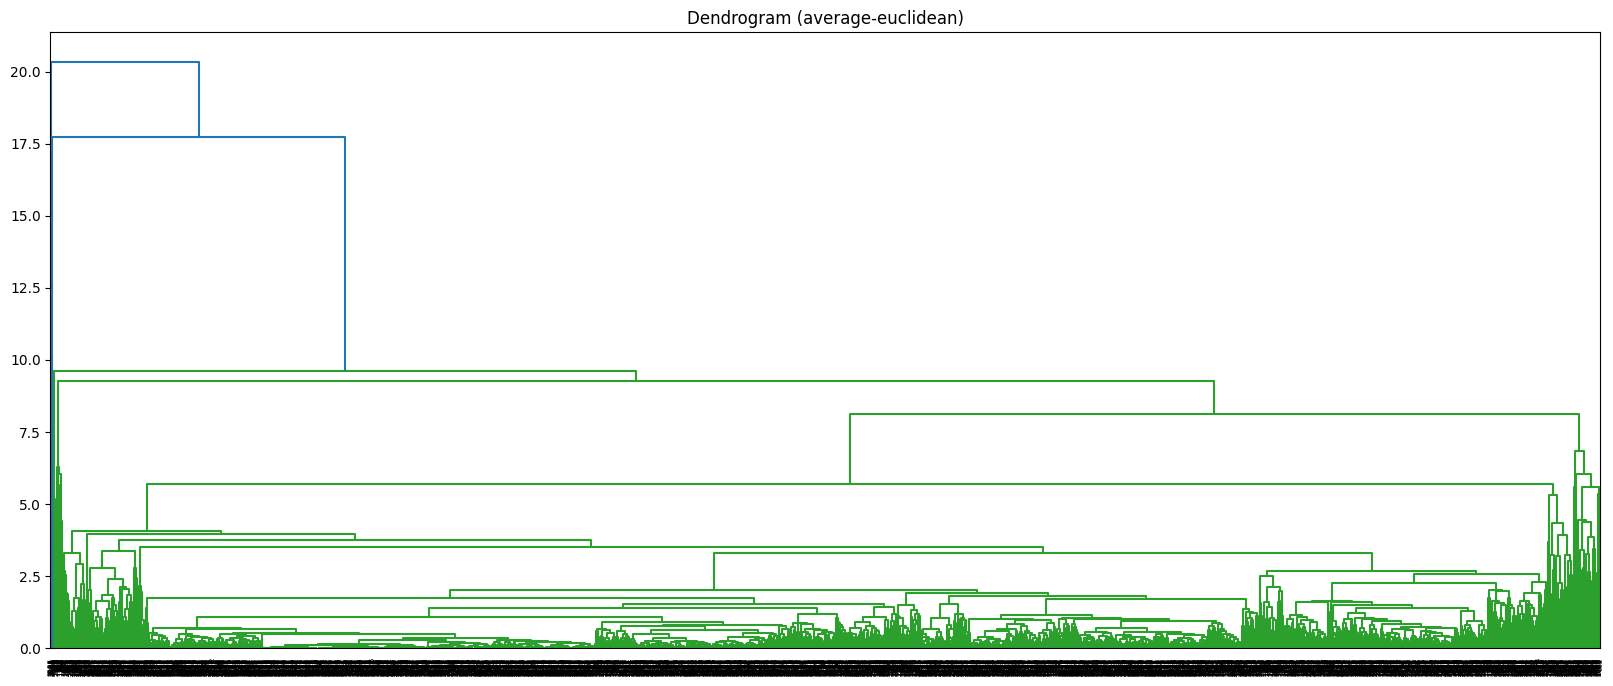

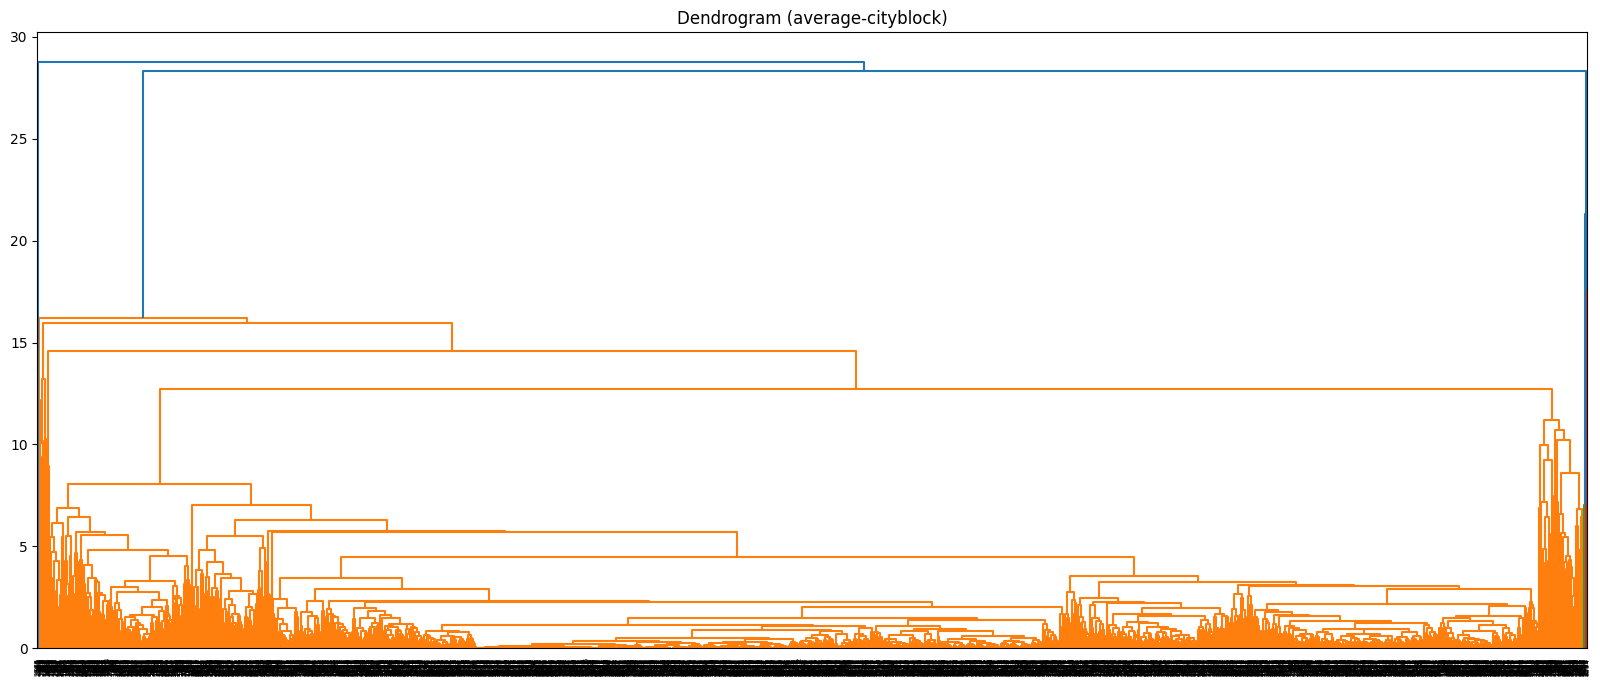

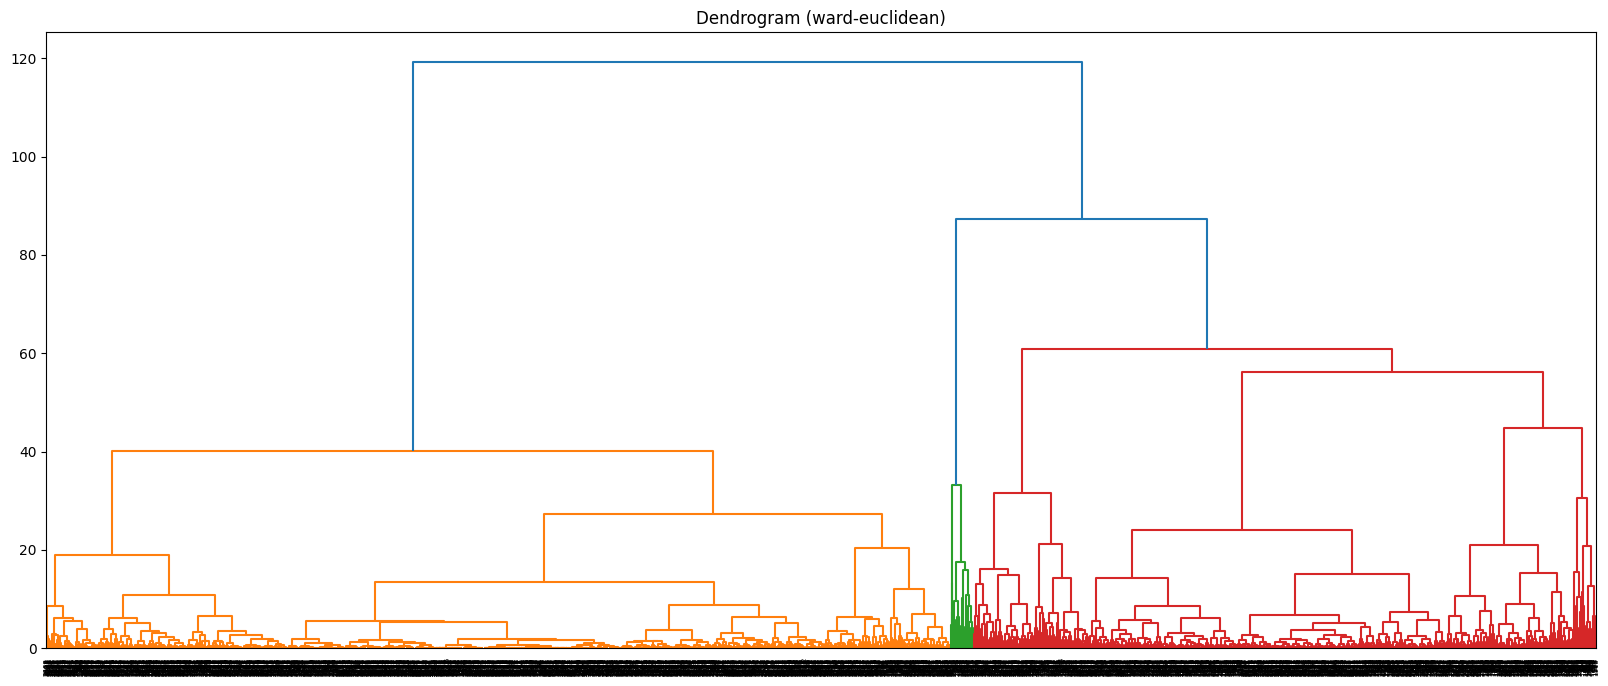

In [13]:
for method, metric in prod:
    # Skip 'ward' with non-Euclidean metrics
    if method in ['centroid', 'ward'] and metric != 'euclidean':
        continue

    z = linkage(x, method=method, metric=metric)

    plt.figure(figsize=(20,8))
    dendrogram(z)
    plt.title(f"Dendrogram ({method}-{metric})")
    plt.show()
    plt.close()

> complete-cityblock를 선택

## #10. 군집 결과 값을 sklearn 패키지에 적용

개별 데이터가 어떤 군집에 속하는지 알아보기 위해서는 sklearn을 사용하는 것이 간편

In [14]:
h_complete = AgglomerativeClustering(n_clusters=3, metric="cityblock", linkage="complete")
h_complete.fit(x)   #학습
h_complete.labels_

array([2, 2, 2, ..., 2, 2, 2], dtype=int64)

### 원본 데이터에 클러스터링 결과 병합

각 고객이 어떤 클러스터에 속하는지 확인할 수 있는 데이터가 생성

In [15]:
origin["Cluster"] = h_complete.labels_
origin.head()

,Balance,Qual_miles,cc1_miles,cc2_miles,cc3_miles,Bonus_miles,Bonus_trans,Flight_miles_12mo,Flight_trans_12,Days_since_enroll,Award,Cluster
ID,,,,,,,,,,,,
1,28143,0,1,1,1,174,1,0,0,7000,0,2
2,19244,0,1,1,1,215,2,0,0,6968,0,2
3,41354,0,1,1,1,4123,4,0,0,7034,0,2
4,14776,0,1,1,1,500,1,0,0,6952,0,2
5,97752,0,4,1,1,43300,26,2077,4,6935,1,2


In [16]:
origin["Cluster"].value_counts()

Cluster
2    3930
0      65
1       4
Name: count, dtype: int64

> 가장 적은 1 그룹이 돈을 많이 사용했다고 판단.

### VIP 고객 추출

In [17]:
# 소수(VIP 추정)인원 추출
origin.query("Cluster == 1")

,Balance,Qual_miles,cc1_miles,cc2_miles,cc3_miles,Bonus_miles,Bonus_trans,Flight_miles_12mo,Flight_trans_12,Days_since_enroll,Award,Cluster
ID,,,,,,,,,,,,
2032,53232,888,4,1,1,80696,65,22100,45,3831,1,1
3257,287033,0,1,1,1,26161,58,12873,53,2272,1,1
3606,160114,500,1,1,1,71954,86,30817,53,1373,1,1
3617,27619,0,4,1,1,83726,68,14050,46,1325,1,1
